<a href="https://colab.research.google.com/github/seoulartgirl/GithubPortfolio/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D10_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%A5%BC%EC%9C%84%ED%95%9C%EB%94%A5%EB%9F%AC%EB%8B%9D1_Bow%EB%B0%A9%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 텍스트를 위한 딥러닝#1

### 텍스트 벡터화

원시 텍스트를 입력으로 사용할 수 있도록 수치 텐서로 변경

- 텍스트 분할(토큰화) : 토큰(문자, 단어, 단어의 그룹) 단위로 분할
- 텍스트 표준화 : 소문자로 변환, 구두점 제거, 불용어 처리 등
- 토큰의 인덱싱 : 토큰을 수치 벡터로 변경

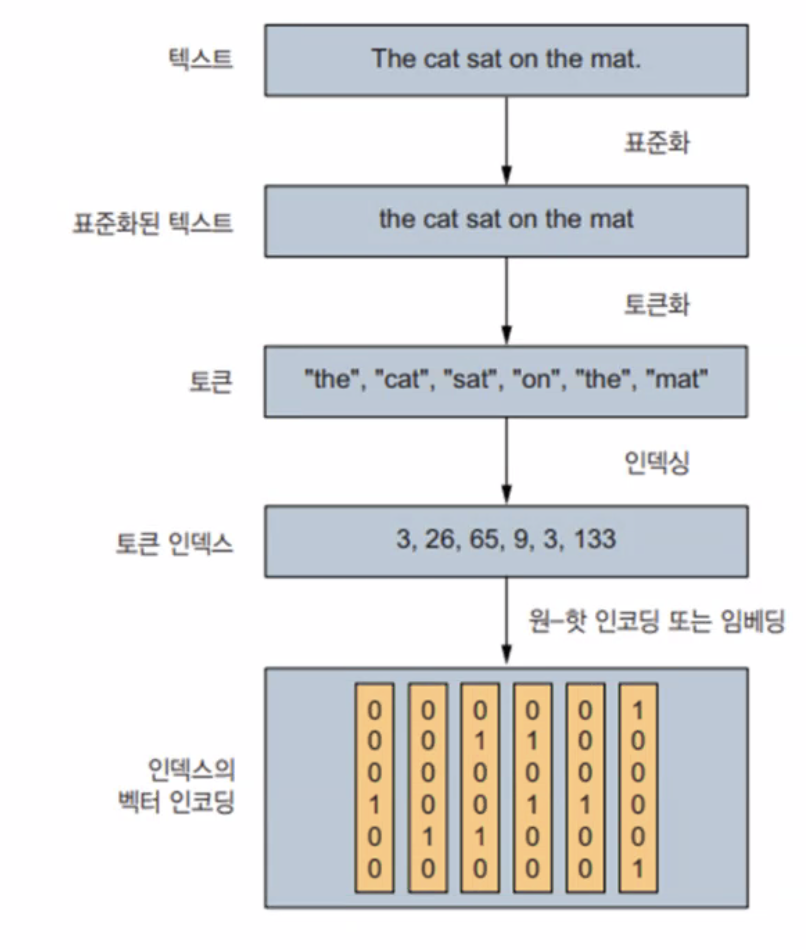

### 단어 그룹을 표현하는 두 가지 방법

- BoW 모델
    - 순서를 무시하고 텍스트를 단어의 (순서없는) 집합으로 처리
    - Count기반, TF-IDF기반
    - keras.layers.TextVectorization()
- 시퀀스(sequence) 모델
    - 시계열의 타임스텝처럼 한 번에 하나의 단어씩 등장하는 순서대로 처리
    - 순환신경망, 트랜스포머
    - keras.layers.Embedding()

## BoW(집합) 모델

### 텍스트 벡터화를 위한 코드

In [ ]:
import string

class Vectorizer:
    def standardize(self, text):
        text = text.lower() #소문자 변경 - 표준화
        return "".join(char for char in text if char not in string.punctuation)

    def tokenize(self, text):
        return text.split()

    def make_vocabulary(self, dataset):
        self.vocabulary = {"": 0, "[UNK]": 1}   # [UNK] : Out Of Vocabulary
        for text in dataset:
            text = self.standardize(text)
            tokens = self.tokenize(text)
            for token in tokens:
                if token not in self.vocabulary:
                    self.vocabulary[token] = len(self.vocabulary)
        self.inverse_vocabulary = dict(
            (v, k) for k, v in self.vocabulary.items())

    def encode(self, text):
        text = self.standardize(text)
        tokens = self.tokenize(text)
        return [self.vocabulary.get(token, 1) for token in tokens]

    def decode(self, int_sequence):
        return " ".join(
            self.inverse_vocabulary.get(i, "[UNK]") for i in int_sequence)

In [ ]:
vect = Vectorizer()

In [ ]:
dataset = ['I love you',
           'A popy blooms',
           'Woo Woo!!',
           'I like apple']

In [ ]:
vect.make_vocabulary(dataset)

In [ ]:
vect.vocabulary

{'': 0,
 '[UNK]': 1,
 'i': 2,
 'love': 3,
 'you': 4,
 'a': 5,
 'popy': 6,
 'blooms': 7,
 'woo': 8,
 'like': 9,
 'apple': 10}

In [ ]:
test_sentence = 'I write, you love,'
encoded = vect.encode(test_sentence)
encoded

[2, 1, 4, 3]

In [ ]:
vect.decode(encoded)

'i [UNK] you love'

### 케라스의 `TextVectorization` 층

**tf.keras.layers.TextVectorization()**

https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization

```python
tf.keras.layers.TextVectorization(max_tokens=None, #단어수 ex.5000개
                                  standardize='lower_and_strip_punctuation', #표준화
                                  split='whitespace', #공백기준 split
                                  ngrams=None,
                                  output_mode='int', #벡터화할 때 정수인덱스(0또는 1)로 만들어줌
                                  output_sequence_length=None,
                                  pad_to_max_tokens=False,
                                  vocabulary=None,
                                  idf_weights=None,
                                  sparse=False,
                                  ragged=False,
                                  encoding='utf-8',
                                  name=None,
                                  **kwargs
                                 )
```

#### TextVectorization층 사용
- 정수인덱스로 인코딩된 단어 시퀀스 반환

In [ ]:
from tensorflow import keras
from keras.layers import TextVectorization

text_vector = TextVectorization(output_mode='int')

- 사용자 정의 함수를 활용한 표준화, 토큰화

In [ ]:
import re
import string
import tensorflow as tf

def my_standardize(string_tensor):
    lower = tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(lower, f'[{re.escape(string.punctuation)}]', ' ')

def my_tokenize(string_tensor):
    return tf.strings.split(string_tensor)

#### 말뭉치 어휘 사전 인덱싱과 출력

- 어휘 사전 인덱싱 : adapt() 메서드

In [ ]:
text_vector = TextVectorization(
    output_mode='int',
    standardize=my_standardize,
    split=my_tokenize)

- 어휘 사전 출력 : get_vocabulary() 메서드

In [ ]:
dataset

['I love you', 'A popy blooms', 'Woo Woo!!', 'I like apple']

In [ ]:
text_vector.adapt(dataset)

In [ ]:
print(text_vector.get_vocabulary())

['', '[UNK]', 'woo', 'i', 'you', 'popy', 'love', 'like', 'blooms', 'apple', 'a']


#### 문장 인코딩과 디코딩

In [ ]:
vocabs = text_vector.get_vocabulary()
test_sentence = 'I love you too'
encoded_sentence = text_vector(test_sentence)

In [ ]:
print(encoded_sentence)

tf.Tensor([3 6 4 1], shape=(4,), dtype=int64)


In [ ]:
inverse_vocabs = dict(enumerate(vocabs))
print(inverse_vocabs)

{0: '', 1: '[UNK]', 2: 'woo', 3: 'i', 4: 'you', 5: 'popy', 6: 'love', 7: 'like', 8: 'blooms', 9: 'apple', 10: 'a'}


In [ ]:
[inverse_vocabs[int(i)] for i in encoded_sentence]

['i', 'love', 'you', '[UNK]']

In [ ]:
decoded_sentence = ' '.join([inverse_vocabs[int(i)] for i in encoded_sentence])
print(decoded_sentence)

i love you [UNK]


---

## BoW 기반 모델링 실습

### 예제 데이터: IMDB 영화 리뷰

#### 데이터 다운로드

In [ ]:
!wget http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz

--2024-06-19 04:54:22--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘aclImdb_v1.tar.gz’

aclImdb_v1.tar.gz   100%[===================>]  80.23M  8.54MB/s    in 15s     

2024-06-19 04:54:37 (5.45 MB/s) - ‘aclImdb_v1.tar.gz’ saved [84125825/84125825]



In [ ]:
!tar -xf aclImdb_v1.tar.gz

In [ ]:
!rm -r aclImdb/train/unsup

In [ ]:
# 코드로 파일 지워버리는 방법
# !rm -r aclImdb/val

#### 데이터 확인

In [ ]:
!cat aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

#### 훈련, 검증, 테스트 데이터 준비

In [ ]:
import os, pathlib, random, shutil

base_dir = pathlib.Path('aclImdb') #폴더 경로 이름
train_dir = base_dir / 'train'
val_dir = base_dir / 'val'
test_dir = base_dir / 'test'

print(train_dir) #경로명이 들어가 있음

aclImdb/train


In [ ]:
for category in ('neg', 'pos'):
    os.makedirs(val_dir / category) # 경로(디렉토리) 만들기
    files = os.listdir(train_dir / category)
    random.Random(1237).shuffle(files)
    num_val_samples = int(0.2 * len(files)) #셔플의 앞 20%를 validation 샘플로 이용
    val_files = files[-num_val_samples:] #뒤에 있는 데이터들이 val 데이터로 들어감
    for fname in val_files: #코드로 파일 옮기기
        shutil.move(train_dir / category / fname, #원본소스
                    val_dir / category / fname) #validation 디렉토리


In [ ]:
batch_size = 32
train_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/train', batch_size=batch_size)
val_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/val', batch_size=batch_size)
test_ds = keras.utils.text_dataset_from_directory(
    'aclImdb/test', batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


- 첫 번째 배치의 크기와 dtype 출력

In [ ]:
for inputs, targets in train_ds:
    print("inputs.shape=", inputs.shape)
    print("inputs.dtype=", inputs.dtype)
    print("targets.shape=", targets.shape)
    print("targets.dtype=", targets.dtype)
    print(f'inputs[1]= {inputs[0]}')
    print(f'targets[1]= {targets[0]}')
    break #break를 안하면 계속 32개씩 데이터를 가져옴

inputs.shape= (32,)
inputs.dtype= <dtype: 'string'>
targets.shape= (32,)
targets.dtype= <dtype: 'int32'>
inputs[1]= b'It is a great movie if you have ever named your cars or are really into old, fast, or exotic cars. It has a plot and a lot of action. The car scenes are great except for the totally fake car jump scene. All of the other scenes are great. I really enjoyed it and I hope everyone else does as well.'
targets[1]= 1


#### 1) 이진인코딩(binary encoding) 사용한 유니그램(unigram) 방식
: unigram = Single words

**`TextVectorization` 층으로 데이터 전처리**

In [ ]:
text_vect = keras.layers.TextVectorization(max_tokens=20000,
                                           output_mode='multi_hot')
#input, target중 input(x)만 받음
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vect.adapt(text_only_train_ds)

# multi_hot 이긴 하지만 이진 인코딩으로
# num_parallel_calls=4 : 다중 CPU 코어 활용을 위한 매개변수 - 코어 수 지정
bin_1gram_train_ds = train_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)
bin_1gram_val_ds = val_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)
bin_1gram_test_ds = test_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)

**이진 유니그램 데이터셋의 출력 확인**

In [ ]:
for inputs, targets in bin_1gram_train_ds:
    print("inputs.shape=", inputs.shape)
    print("inputs.dtype=", inputs.dtype)
    print("targets.shape=", targets.shape)
    print("targets.dtype=", targets.dtype)
    print(f'inputs[0]= {inputs[0]}')
    print(f'targets[0]= {targets[0]}')
    break

inputs.shape= (32, 20000)
inputs.dtype= <dtype: 'float32'>
targets.shape= (32,)
targets.dtype= <dtype: 'int32'>
inputs[0]= [1. 1. 1. ... 0. 0. 0.]
targets[0]= 1


**모델 생성**

In [ ]:
from keras import layers, Input, Model

def build_model(max_tokens = 20000, hidden_dim=16): #20,000차원
    inputs = Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation='relu')(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics = ['accuracy'])
    return model

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**모델 훈련 및 테스트**

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/GithubPortfolio/DeepLearning/model/'

In [ ]:
model = build_model()
model.summary()
model_name = model_path + 'aclImdb_binary_1gram.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)]
history = model.fit(bin_1gram_train_ds.cache(), #모델 찌꺼기들 저장 후 fit
                    validation_data=bin_1gram_val_ds.cache(),
                    epochs=10,
                    callbacks=callbacks)
best_model = keras.models.load_model(model_name)
print(f'테스트 정확도 : {best_model.evaluate(bin_1gram_test_ds)[1]:.4f}')

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
623/625 [============================>.] - ETA: 0s - loss: 0.4174 - accuracy: 0.8236

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 7s 8ms/step - loss: 0.4170 - accuracy: 0.8238 - val_loss: 0.2834 - val_accuracy: 0.8872
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2771 - accuracy: 0.8984 - val_loss: 0.2715 - val_accuracy: 0.8950
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2388 - accuracy: 0.9143 - val_loss: 0.2816 - val_accuracy: 0.8930
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2304 - accuracy: 0.9222 - val_loss: 0.2970 - val_accuracy: 0.8916
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2206 - accuracy: 0.9297 - val_loss: 0.3033 - val_accuracy: 0.8952
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2158 - accuracy: 0.9305 - val_loss: 0.3139 - val_accuracy: 0.8900
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2037 - accuracy: 0.9347 - val_loss: 0.3243 - val_accuracy: 0.8940
Epoch 8/10
625/62

#### 2) 이진 인코딩을 사용한 바이그램

**바이그램을 반환하는 `TextVectorization` 층 만들기**

In [ ]:
text_vect = keras.layers.TextVectorization(max_tokens=20000,
                                           output_mode='multi_hot',
                                          ngrams=2)

#input, target중 input(x)만 받음
text_only_train_ds = train_ds.map(lambda x, y: x)
text_vect.adapt(text_only_train_ds)

# num_parallel_calls=4 : 다중 CPU 코어 활용을 위한 매개변수 - 코어 수 지정
bin_2gram_train_ds = train_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)
bin_2gram_val_ds = val_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)
bin_2gram_test_ds = test_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)

**이진 바이그램 모델 훈련 및 테스트**

In [ ]:
model = build_model()
model.summary()
model_name = model_path + 'aclImdb_binary_2gram.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)]
history = model.fit(bin_2gram_train_ds.cache(), #모델 찌꺼기들 저장 후 fit
                    validation_data=bin_2gram_val_ds.cache(),
                    epochs=10,
                    callbacks=callbacks)
best_model = keras.models.load_model(model_name)
print(f'테스트 정확도 : {best_model.evaluate(bin_2gram_test_ds)[1]:.4f}')

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_8 (Dense)             (None, 16)                320016    
                                                                 
 dropout_4 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3977 - accuracy: 0.8342 - val_loss: 0.2725 - val_accuracy: 0.8918
Epoch 2/10
62

#### 3) TF-IDF 인코딩을 사용한 바이그램

**토큰 카운트를 반환하는 `TextVectorization` 층**

In [ ]:
text_vect = keras.layers.TextVectorization(max_tokens=20000,
                                           output_mode='count',
                                           ngrams=2)

**TF-IDF 가중치가 적용된 출력을 반환하는 `TextVectorization` 층**

In [ ]:
text_vect = keras.layers.TextVectorization(max_tokens=20000,
                                           output_mode='tf_idf',
                                           ngrams=2)

**TF-IDF 바이그램 모델 훈련하고 테스트하기**

In [ ]:
text_vect.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(lambda x,y: (text_vect(x), y), num_parallel_calls=4)

In [ ]:
model = build_model()
model.summary()
model_name = model_path + 'aclImdb_tfidf_2gram.h5'

callbacks = [keras.callbacks.ModelCheckpoint(model_name, save_best_only=True)]
history = model.fit(tfidf_2gram_train_ds.cache(), #모델 찌꺼기들 저장 후 fit
                    validation_data=tfidf_2gram_val_ds.cache(),
                    epochs=10,
                    callbacks=callbacks)
best_model = keras.models.load_model(model_name)
print(f'테스트 정확도 : {best_model.evaluate(tfidf_2gram_test_ds)[1]:.4f}')

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_10 (Dense)            (None, 16)                320016    
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 320033 (1.22 MB)
Trainable params: 320033 (1.22 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
625/625 [==============================] - 3s 4ms/step - loss: 0.3990 - accuracy: 0.8325 - val_loss: 0.2797 - val_accuracy: 0.8912
Epoch 2/10
 5

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


625/625 [==============================] - 2s 4ms/step - loss: 0.2621 - accuracy: 0.9093 - val_loss: 0.2795 - val_accuracy: 0.8940
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2140 - accuracy: 0.9285 - val_loss: 0.2975 - val_accuracy: 0.8890
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1975 - accuracy: 0.9368 - val_loss: 0.3122 - val_accuracy: 0.8880
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1887 - accuracy: 0.9445 - val_loss: 0.3233 - val_accuracy: 0.8892
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1811 - accuracy: 0.9481 - val_loss: 0.3446 - val_accuracy: 0.8864
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1742 - accuracy: 0.9498 - val_loss: 0.3572 - val_accuracy: 0.8802
Epoch 8/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1652 - accuracy: 0.9528 - val_loss: 0.3733 - val_accuracy: 0.8786
Epoch 9/10
625/62

- 이진 유니그램으로 벡터화한 경우 분류 성능
    - 테스트 정확도 : 0.8884
- 이진 바이어그램으로 벡터화한 경우 모델 성능
    - 테스트 정확도 :  0.8991
- TF-IDF 바이어그램으로 벡터화한 경우 모델 성능
    - 테스트 정확도 :  0.8940

---